[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/anaC-Fernandes/ProjetoDados/blob/main/Notebooks/Dataset_Crise.ipynb)

### **Tema:** 📉 Crise
### **Pergunta:** 9. A partir da análise do PIB, quais regiões se recuperaram da recessão de 2014-2016?



# **Preparação dos Dados**

### **Manipulação Inicial do dados sobre Crise**

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from unidecode import unidecode
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import jinja2
import csv
import re
import ast
import re
from collections import Counter

### **Tabela BrStats**

Lendo o arquivo **BrStats** e definindo ';' como separador.

In [95]:
dados = pd.read_csv('https://raw.githubusercontent.com/anaC-Fernandes/ProjetoDados/refs/heads/main/Datasets/BrStats.csv', sep = ';', low_memory= False)
dados

,Ano,CDMunicipio,Populacao,PessoalOcupado,PessoalAssalariado,VrSalarios,PIB,QtEmpresas,AreaPlantada_h,AreaColhida_h,...,Exportacoes_US$,Receitas_R$,Transferencias_correntes_R$,Transferencias_capital_R$,NrNascimentos,NrObitosInfantis,povoamento,UF,Municipio,Regiao
0,2016,3509452,5.932,854,537,13.692,111.190,"252,00","38,00","38,00",...,NaN,"25.511.889,220","18.911.068,400","1.665.392,540","80,00","0,00","32,065",SP,Campina do Monte Alegre,Sudeste
1,2016,3123601,27.505,5.680,4.778,104.977,554.663,"671,00","3,00","3,00",...,"1.777.256,000","63.002.672,933","45.304.154,440","538.882,600","299,00","3,00","55,065",MG,Elói Mendes,Sudeste
2,2016,3552007,6.193,668,580,12.519,62.441,"83,00","0,00","0,00",...,NaN,"30.492.825,449","21.861.157,950","1.048.458,040","59,00","2,00","14,930",SP,Silveiras,Sudeste
3,2016,3305604,21.279,3.087,2.669,80.161,403.121,"290,00","0,00","0,00",...,NaN,"140.538.926,872","100.508.822,360","871.234,340","272,00","2,00","22,698",RJ,Silva Jardim,Sudeste
4,2016,1717008,4.534,212,183,5.309,48.551,"34,00","94,00","34,00",...,NaN,"15.541.375,953","13.178.989,760","8.037,870","43,00","1,00","2,908",TO,Pindorama do Tocantins,Norte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33415,2021,2705408,7.171,463,436,10.502,NaN,"32,00","0,00","0,00",...,NaN,NaN,NaN,NaN,"135,00","3,00","83,287",AL,Monteirópolis,Nordeste
33416,2021,1600105,9.265,428,383,9.932,NaN,"38,00","0,00","0,00",...,NaN,NaN,NaN,NaN,"160,00","2,00","1,010",AP,Amapá,Norte
33417,2019,2605459,3.061,2.210,1.773,43.093,192.775,"289,00","0,00","0,00",...,NaN,NaN,NaN,NaN,"32,00","1,00","180,059",PE,Fernando de Noronha,Nordeste
33418,2020,1503002,7.070,538,514,12.207,63.579,"32,00","0,00","0,00",...,NaN,NaN,NaN,NaN,"149,00","4,00","0,601",PA,Faro,Norte


#### Tabela BrStats contendo apenas 'UF', 'Municipio', 'Regiao'e 'PIB'

Para responder a pergunta **9. A partir da análise do PIB, quais municípios se recuperaram da recessão de 2014-2016?** precisaremos apenas dos seguintes dados:
- UF
- Municipio
- Regiao
- PIB
- Ano

Por esse motivo fizemos uma filtragem na tabela BrStats, retirando os dados não necessãrios para essa pergunta.

In [96]:
dados_filtrados = dados[['UF', 'Municipio', 'Regiao', 'PIB', 'Ano']]

dados_filtrados

,UF,Municipio,Regiao,PIB,Ano
0,SP,Campina do Monte Alegre,Sudeste,111.190,2016
1,MG,Elói Mendes,Sudeste,554.663,2016
2,SP,Silveiras,Sudeste,62.441,2016
3,RJ,Silva Jardim,Sudeste,403.121,2016
4,TO,Pindorama do Tocantins,Norte,48.551,2016
...,...,...,...,...,...
33415,AL,Monteirópolis,Nordeste,NaN,2021
33416,AP,Amapá,Norte,NaN,2021
33417,PE,Fernando de Noronha,Nordeste,192.775,2019
33418,PA,Faro,Norte,63.579,2020


É possível salvar a nova tabela em um arquivo .csv separado:

In [97]:
dados_filtrados.to_csv("BrStats_crise.csv", index=False)

### **Tabela sidra**

Como mencionado no README, fizemos uma busca no Sidra para encontrar dados do PIB dos municípios brasileiros dos anos de 2013 (anterior a crise) até 2016 (fim da crise), o arquivo gerado é o sidra.csv.

Abaixo estamos carregando e manipulando o arquivo sidra, para que possamos unir as duas tabelas de dados.

In [98]:
# Carregando o arquivo CSV com a codificação correta UTF-8, pois estava perdendo acentos
dados_sidra = pd.read_csv('https://raw.githubusercontent.com/anaC-Fernandes/ProjetoDados/refs/heads/main/Datasets/sidra.csv', skiprows=1, encoding='utf-8')

# Renomeando as colunas
dados_sidra.columns = ['Município', '2013', '2014', '2015', '2016', '2017']

# Removendo linhas sem dados úteis que vieram do PDF (Fonte, Notas, etc.)
dados_sidra = dados_sidra.dropna() 
dados_sidra = dados_sidra[~dados_sidra['Município'].str.contains('Fonte:|Notas|1 -', na=False)] 

# Salvando o arquivo corrigido com codificação UTF-8
dados_sidra.to_csv('sidra_limpos.csv', index=False, encoding='utf-8-sig')

Um detalhe a ser corrigido antes de unirmos as tabelas do BrStats com a do Sidra é a maneira como municípios e UF estão registrados, enquanto o dataset BrStats possui uma coluna chamada 'UF', o dataset do Sidra escreve a UF na mesma coluna do município, e por isso devemos criar uma nova coluna nesse dataset.

In [99]:
# Criando a coluna UF
if 'UF' not in dados_sidra.columns:
    dados_sidra['UF'] = ''

# Separaando Município e UF
dados_sidra[['Município', 'UF']] = dados_sidra['Município'].str.extract(r'(.+) \((\w{2})\)')

dados_sidra

,Município,2013,2014,2015,2016,2017,UF
0,Alta Floresta D'Oeste,341.325,377.799,421.300,478.217,485.374,RO
1,Ariquemes,1.799.853,1.921.532,2.037.799,2.184.346,2.287.910,RO
2,Cabixi,96.365,113.477,116.565,133.342,138.110,RO
3,Cacoal,1.433.254,1.660.650,1.794.478,1.947.283,2.082.761,RO
4,Cerejeiras,353.270,392.417,397.736,408.194,439.245,RO
...,...,...,...,...,...,...,...
5565,Vianópolis,291.919,302.880,312.348,373.802,395.861,GO
5566,Vicentinópolis,259.422,275.800,322.298,351.750,350.839,GO
5567,Vila Boa,103.233,90.478,111.229,138.810,118.639,GO
5568,Vila Propício,142.970,138.474,198.935,210.475,182.203,GO


### **Unindo os dois Datasets**

O dataset BrStats não possui colunas específicas para os anos em que os PIBs foram registrados, então optamos por fazer divisão para facilitar a análise.

In [100]:
# Criando um DataFrame onde cada ano vira uma coluna
dados = dados.pivot_table(
    index=['UF', 'Municipio', 'Regiao'],  # Colunas que permanecerão como índice
    columns='Ano',                        # Coluna que será transformada em novas colunas
    values='PIB',                         # Valores que preencherão as novas colunas
    aggfunc='first'                       # Função de agregação (usamos 'first' pois não há duplicatas)
)

# Resetar o índice para trazer UF, Municipio e Regiao de volta como colunas
dados = dados.reset_index()

dados

Ano,UF,Municipio,Regiao,2016,2017,2018,2019,2020
0,AC,Acrelândia,Norte,239.610,229.644,253.138,253.152,302.445
1,AC,Assis Brasil,Norte,85.322,91.743,89.875,92.705,96.920
2,AC,Brasiléia,Norte,388.521,388.018,439.547,454.009,480.142
3,AC,Bujari,Norte,159.696,158.301,158.191,159.100,183.818
4,AC,Capixaba,Norte,177.480,170.990,164.238,152.806,145.318
...,...,...,...,...,...,...,...,...
5560,TO,Tocantínia,Norte,61.070,67.831,71.807,129.131,135.159
5561,TO,Tupirama,Norte,46.019,46.142,49.166,55.980,94.549
5562,TO,Tupiratins,Norte,28.051,28.582,29.772,29.993,33.798
5563,TO,Wanderlândia,Norte,154.098,161.897,140.641,134.885,149.907


Outro problema a ser corrigido é a coluna 'Municipio' no dataset do Sidra, que possui acentuação, enquanto a do BrStats não possui, e precisaremos que elas possuam nomeclatura idêntica para uni-las.

In [101]:
dados_sidra = dados_sidra.rename(columns={'Município': 'Municipio'})

Unindo os dois datasets utilizando como base as colunas 'Municipio' e 'UF'.

In [102]:
dados_crise = dados.merge(dados_sidra, on=['Municipio', 'UF'])

# Salvar o arquivo corrigido com codificação UTF-8
dados_crise.to_csv('dados_crise.csv', index=False, encoding='utf-8-sig')

dados_crise

,UF,Municipio,Regiao,2016,2017,2018,2019,2020,2013,2014,2015,2016,2017
0,AC,Acrelândia,Norte,239.610,229.644,253.138,253.152,302.445,214.652,207.822,212.961,239.610,229.644
1,AC,Assis Brasil,Norte,85.322,91.743,89.875,92.705,96.920,64.602,73.332,77.234,85.322,91.743
2,AC,Brasiléia,Norte,388.521,388.018,439.547,454.009,480.142,294.874,340.917,388.114,388.521,388.018
3,AC,Bujari,Norte,159.696,158.301,158.191,159.100,183.818,120.210,129.895,147.868,159.696,158.301
4,AC,Capixaba,Norte,177.480,170.990,164.238,152.806,145.318,158.800,149.067,160.134,177.480,170.990
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5444,TO,Tocantínia,Norte,61.070,67.831,71.807,129.131,135.159,47.927,49.172,58.998,61.070,67.831
5445,TO,Tupirama,Norte,46.019,46.142,49.166,55.980,94.549,79.472,68.282,47.485,46.019,46.142
5446,TO,Tupiratins,Norte,28.051,28.582,29.772,29.993,33.798,21.891,25.998,24.533,28.051,28.582
5447,TO,Wanderlândia,Norte,154.098,161.897,140.641,134.885,149.907,125.772,134.428,138.573,154.098,161.897


É possível perceber que o dataset ainda precisa de alguns ajustes, como ordenar corretamente os anos e remover os que se repetem.

In [103]:
dados_crise = pd.read_csv('dados_crise.csv')
dados_crise

,UF,Municipio,Regiao,2016,2017,2018,2019,2020,2013,2014,2015,2016.1,2017.1
0,AC,Acrelândia,Norte,239.610,229.644,253.138,253.152,302.445,214.652,207.822,212.961,239.610,229.644
1,AC,Assis Brasil,Norte,85.322,91.743,89.875,92.705,96.920,64.602,73.332,77.234,85.322,91.743
2,AC,Brasiléia,Norte,388.521,388.018,439.547,454.009,480.142,294.874,340.917,388.114,388.521,388.018
3,AC,Bujari,Norte,159.696,158.301,158.191,159.100,183.818,120.210,129.895,147.868,159.696,158.301
4,AC,Capixaba,Norte,177.480,170.990,164.238,152.806,145.318,158.800,149.067,160.134,177.480,170.990
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5444,TO,Tocantínia,Norte,61.070,67.831,71.807,129.131,135.159,47.927,49.172,58.998,61.070,67.831
5445,TO,Tupirama,Norte,46.019,46.142,49.166,55.980,94.549,79.472,68.282,47.485,46.019,46.142
5446,TO,Tupiratins,Norte,28.051,28.582,29.772,29.993,33.798,21.891,25.998,24.533,28.051,28.582
5447,TO,Wanderlândia,Norte,154.098,161.897,140.641,134.885,149.907,125.772,134.428,138.573,154.098,161.897


In [104]:
# Removendo colunas duplicadas
cols_to_remove = ['2016.1', '2017.1']
dados_crise = dados_crise.drop(columns=[col for col in cols_to_remove if col in dados_crise.columns])

# Reordenando colunas
fixed_cols = ['UF', 'Municipio', 'Regiao']
year_cols = sorted([col for col in dados_crise.columns if col.isdigit()])
dados_crise = dados_crise[fixed_cols + year_cols]

# Salvando o resultado
output_file = '.dados_final.csv'
dados_crise.to_csv(output_file, index=False)

dados_crise

,UF,Municipio,Regiao,2013,2014,2015,2016,2017,2018,2019,2020
0,AC,Acrelândia,Norte,214.652,207.822,212.961,239.610,229.644,253.138,253.152,302.445
1,AC,Assis Brasil,Norte,64.602,73.332,77.234,85.322,91.743,89.875,92.705,96.920
2,AC,Brasiléia,Norte,294.874,340.917,388.114,388.521,388.018,439.547,454.009,480.142
3,AC,Bujari,Norte,120.210,129.895,147.868,159.696,158.301,158.191,159.100,183.818
4,AC,Capixaba,Norte,158.800,149.067,160.134,177.480,170.990,164.238,152.806,145.318
...,...,...,...,...,...,...,...,...,...,...,...
5444,TO,Tocantínia,Norte,47.927,49.172,58.998,61.070,67.831,71.807,129.131,135.159
5445,TO,Tupirama,Norte,79.472,68.282,47.485,46.019,46.142,49.166,55.980,94.549
5446,TO,Tupiratins,Norte,21.891,25.998,24.533,28.051,28.582,29.772,29.993,33.798
5447,TO,Wanderlândia,Norte,125.772,134.428,138.573,154.098,161.897,140.641,134.885,149.907


Com isso obtivemos um dataset com apenas os dados necessários para a análise do PIB antes, durante e depois da crise de 2014-2016.

In [105]:
for col in year_cols:
    dados_crise[col] = (
        dados_crise[col]
        .str.replace('.', '', regex=False)  
        .str.replace(',', '.', regex=False)  
        .astype(float)  
    )

dados_crise[['UF', 'Municipio', 'Regiao']] = dados_crise[['UF', 'Municipio', 'Regiao']].astype('string')

dados_crise.dtypes

UF           string[python]
Municipio    string[python]
Regiao       string[python]
2013                float64
2014                float64
2015                float64
2016                float64
2017                float64
2018                float64
2019                float64
2020                float64
dtype: object

# **Entrega 4 - Regressão Linear**

Para o desenvolvimento da entrega 4, seguimos o artigo "Resultado primário pós-crise econômica de 2014: um estudo nos municípios brasileiros no exercício de 2016", de Allan Jonson Piccini, e optamos por adicionar dados retirados do Finbra (Finanças do Brasil), então a sessão a seguir mostrará o carregamento e tratamento das tabelas obtidas do Finbra, com as receitas dos municípios do Brasil dos anos de 2013 até 2016. 

## Manipulação Inicial

### **Receitas obtidas pelo Finbra**

Para a utilização dos dados obtidos do Finbra fizemos diversas manipulações para remover e renomear colunas, tais alterações foram exportadas para arquivos, e esses arquivos foram colocados no github, abaixo estamos importandos os dataframes retirados do Finbra, já tratados.

In [106]:
df_transformado_2013 = pd.read_csv('https://raw.githubusercontent.com/anaC-Fernandes/ProjetoDados/refs/heads/main/Datasets/df_transformado_2013.csv', sep=',', low_memory=False)
df_transformado_2014 = pd.read_csv('https://raw.githubusercontent.com/anaC-Fernandes/ProjetoDados/refs/heads/main/Datasets/df_transformado_2014.csv', sep=',', low_memory=False)
df_transformado_2015 = pd.read_csv('https://raw.githubusercontent.com/anaC-Fernandes/ProjetoDados/refs/heads/main/Datasets/df_transformado_2015.csv', sep=',', low_memory=False)   
df_transformado_2016 = pd.read_csv('https://raw.githubusercontent.com/anaC-Fernandes/ProjetoDados/refs/heads/main/Datasets/df_transformado_2016.csv', sep=',', low_memory=False)   

### **Juntando Datasets**

In [107]:
receita = pd.read_csv('https://raw.githubusercontent.com/anaC-Fernandes/ProjetoDados/refs/heads/main/Datasets/BrStats.csv', sep = ';', low_memory= False)

receita = receita[['Receitas_R$', 'Municipio', 'Regiao', 'UF']]

df_transformado_2013 = df_transformado_2013.rename(columns={'Município': 'Municipio'})

df_transformado_2013.to_csv('df_transformado_2013.csv', index=False)

A função abaixo será utilizada para unir o datasef dados_crise, que contém os PIBs reais de cada municípios, com a receita desses municípios em determinado anos, unindo o df_transformado_2013 com o PIB do ano de 2013 retirado de dados_crise.

In [108]:
# Sua linha de formatação global está correta para quando as colunas forem float:
pd.options.display.float_format = lambda x: "{:,.2f}".format(x).replace(',', '@TEMP@').replace('.', ',').replace('@TEMP@', '.')

def limpar_valor_monetario(valor):
    """Converte uma string monetária (ex: '1.234,56') para float."""
    if pd.isna(valor): 
        return pd.NA
    if isinstance(valor, (int, float)):
        return float(valor)
    if isinstance(valor, str):
        valor_limpo = valor.strip()
        if ',' in valor_limpo and '.' in valor_limpo:
            if valor_limpo.rfind('.') > valor_limpo.rfind(','): 
                valor_limpo = valor_limpo.replace('.', '') 
                valor_limpo = valor_limpo.replace(',', '.') 
            else: 
                valor_limpo = valor_limpo.replace('.', '') 
                valor_limpo = valor_limpo.replace(',', '.') 
        elif ',' in valor_limpo: 
            valor_limpo = valor_limpo.replace(',', '.')
        try:
            return float(valor_limpo)
        except ValueError:
            return pd.NA # Retorna pd.NA se a conversão falhar
    return pd.NA

def normalize_text(texto):
    """Normaliza texto: string, strip, upper, unidecode."""
    if pd.isna(texto):
        return pd.NA
    try:
        texto_str = str(texto).strip().upper()
        return unidecode(texto_str)
    except Exception:
        return pd.NA

def preparar_dados_municipais(
    df_receitas: pd.DataFrame,
    df_despesas: pd.DataFrame,
    df_pib: pd.DataFrame,
    ano: str  # ex: '2013'
) -> pd.DataFrame | None:
    df_receitas_proc = df_receitas.copy()
    df_despesas_proc = df_despesas.copy()
    df_pib_proc = df_pib.copy()

    # --- NORMALIZAÇÃO ---
    for df, nome_df in [(df_pib_proc, 'PIB'), (df_receitas_proc, 'Receitas'), (df_despesas_proc, 'Despesas')]:
        if 'Municipio' in df.columns:
            df['Municipio'] = df['Municipio'].apply(normalize_text)
        if 'UF' in df.columns:
            df['UF'] = df['UF'].apply(normalize_text)

    # --- VERIFICAÇÃO DE COLUNAS ---
    colunas_pib_necessarias = ['Municipio', 'UF', 'Regiao', ano]
    colunas_receita_necessarias = ['Municipio', 'UF', 'Receitas_R$']
    colunas_despesa_necessarias = ['Municipio', 'UF', 'População', 'Total Despesa']
    # (Seu loop de verificação de colunas aqui...)
    for df_check, nome, colunas in [
        (df_pib_proc, 'df_pib', colunas_pib_necessarias),
        (df_receitas_proc, 'df_receitas', colunas_receita_necessarias),
        (df_despesas_proc, 'df_despesas', colunas_despesa_necessarias)
    ]:
        if not all(col in df_check.columns for col in colunas):
            print(f"Erro: Faltam colunas em {nome}. Esperadas: {colunas}. Colunas presentes: {df_check.columns.tolist()}")
            return None
            
    # --- LIMPEZA E CONVERSÃO INICIAL ---
    try:
        df_pib_proc[ano] = df_pib_proc[ano].apply(limpar_valor_monetario)
        df_receitas_proc['Receitas_R$'] = df_receitas_proc['Receitas_R$'].apply(limpar_valor_monetario)
        df_despesas_proc['Total Despesa'] = df_despesas_proc['Total Despesa'].apply(limpar_valor_monetario)
        
        if 'População' in df_despesas_proc.columns:
            # Limpeza para População, assumindo que pode ter '.' como separador de milhar e precisa ser int/float
            df_despesas_proc['População'] = df_despesas_proc['População'].astype(str).str.replace('.', '', regex=False)
            # Convertido para numérico aqui, pd.NA se não puder.
            df_despesas_proc['População'] = pd.to_numeric(df_despesas_proc['População'], errors='coerce')


    except Exception as e:
        print(f"Erro durante a limpeza e conversão de tipos: {e}")
        return None

    # --- AGREGAÇÃO ---
    # (Suas seções de try-except para agregação de df_pib_agg, df_receitas_agg, df_despesas_agg aqui...)
    try:
        df_pib_agg = df_pib_proc.rename(columns={ano: 'PIB'})
        agg_funcs_pib = {'Regiao': 'first', 'PIB': 'first'}
        df_pib_agg = df_pib_agg.groupby(['Municipio', 'UF'], as_index=False).agg(agg_funcs_pib)
    except Exception as e:
        print(f"Erro ao processar df_pib: {e}")
        return None

    try:
        df_receitas_agg = df_receitas_proc.groupby(['Municipio', 'UF'], as_index=False).agg(
            {'Receitas_R$': 'first'}
        )
    except Exception as e:
        print(f"Erro ao processar df_receitas: {e}")
        return None

    try:
        agg_funcs_despesas = {'Total Despesa': 'first', 'População': 'first'}
        df_despesas_agg = df_despesas_proc.groupby(['Municipio', 'UF'], as_index=False).agg(agg_funcs_despesas)
        
        # População já foi convertida para numérico antes, mas aqui garantimos o tipo Int64 para permitir NAs
        if 'População' in df_despesas_agg.columns:
             df_despesas_agg['População'] = pd.to_numeric(df_despesas_agg['População'], errors='coerce').astype('Int64')

    except Exception as e:
        print(f"Erro ao processar df_despesas: {e}")
        return None

    # --- MERGES ---
    df_merged = pd.merge(df_pib_agg, df_receitas_agg, on=['Municipio', 'UF'], how='inner')
    df_merged = pd.merge(df_merged, df_despesas_agg, on=['Municipio', 'UF'], how='inner')

    if df_merged.empty:
        print("Aviso: O resultado do merge está vazio.")
        return None
    
    # --- ORDENAÇÃO E SELEÇÃO DE COLUNAS FINAIS ---
    colunas_finais = ['Municipio', 'UF', 'Regiao', 'PIB', 'População', 'Receitas_R$', 'Total Despesa']
    colunas_finais_presentes = [col for col in colunas_finais if col in df_merged.columns]
    df_merged = df_merged[colunas_finais_presentes] # Reordena e seleciona

    # !!!!! ADIÇÃO IMPORTANTE AQUI !!!!!
    # Garante que as colunas monetárias e de população sejam do tipo numérico adequado
    # Isso é crucial para que pd.options.display.float_format funcione.
    colunas_para_converter_numeric = ['PIB', 'Receitas_R$', 'Total Despesa']
    for col in colunas_para_converter_numeric:
        if col in df_merged.columns:
            df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce') 
            # errors='coerce' transformará em NaN o que não puder ser convertido

    if 'População' in df_merged.columns:
        # População pode ser Int64 se já foi tratada, mas uma conversão final é segura
        df_merged['População'] = pd.to_numeric(df_merged['População'], errors='coerce').astype('Int64')


    # Verificação de duplicatas (opcional, mas útil para depuração)
    duplicatas_finais = df_merged[df_merged.duplicated(subset=['Municipio', 'UF'], keep=False)]
    if not duplicatas_finais.empty:
        print("ALERTA: Duplicatas ['Municipio', 'UF'] encontradas no DataFrame final!")
        
    return df_merged

In [109]:
df_final_2013 = preparar_dados_municipais(
    df_receitas=receita,
    df_despesas=df_transformado_2013,
    df_pib=dados_crise,
    ano='2013'
)

In [110]:
def adicionar_saldo(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converte colunas de receita e despesa do formato brasileiro para float
    e adiciona a coluna 'Saldo' com a diferença entre elas.
    """

    def parse_brl(value):
        if pd.isna(value):
            return None
        return float(str(value).replace('.', '').replace(',', '.'))

    df['Receitas_R$'] = df['Receitas_R$'].apply(parse_brl)
    df['Total Despesa'] = df['Total Despesa'].apply(parse_brl)

    df['Saldo'] = df['Receitas_R$'] - df['Total Despesa']
    return df


In [111]:
df_final_2013 = adicionar_saldo(df_final_2013)

### **Normalizando os dados**

In [112]:
df_final_2013['PIB'] = df_final_2013['PIB'] / (10**3)
df_final_2013['Saldo'] = df_final_2013['Saldo'] / (10**6)

#Adicionando a tabela percapita
df_final_2013['PIB_per_capita'] = df_final_2013['PIB'] / df_final_2013['População']


### **Remoção dos Outliers e NaNs**

In [113]:
df_final_2013.dropna(inplace=True)

In [114]:
def remover_outliers_iqr(df, colunas, fator=1.5):
    """
    Remove outliers usando o método IQR
    fator: multiplicador do IQR (1.5 é padrão, 3.0 é mais conservador)
    """
    df_clean = df.copy()
    
    for coluna in colunas:
        Q1 = df_clean[coluna].quantile(0.25)
        Q3 = df_clean[coluna].quantile(0.75)
        IQR = Q3 - Q1
        
        limite_inferior = Q1 - fator * IQR
        limite_superior = Q3 + fator * IQR
        
        # Filtrar apenas valores dentro dos limites
        df_clean = df_clean[
            (df_clean[coluna] >= limite_inferior) & 
            (df_clean[coluna] <= limite_superior)
        ]
        
    return df_clean

In [115]:
df_final_2013 = remover_outliers_iqr(df_final_2013,['PIB', 'Saldo'], fator=1.5)

## Regressão Linear Univariada

A ideia nessa etapa é ver o quanto o saldo orçamentário , que é a diferença entre a receita e as despesas de um município, pode explicar o PIB, e subsequentemente usa-lo para prever o PIB de outros municipios, para isso usaremos a regressão linear, o algoritmo que a biblioteca scikit-learn usa para a regressão linear é o OLS (Ordinario Least Squares).

A nossa hipótese é que um municipio, cujo saldo está baixo ou negativo, não tem recursos o suficiente para investir em infra-estrutura e serviços, além de que esse saldo baixo também pode ser um indicativo de mal gerenciamento da verba pública. Todos esses fatores levariam há um mal gerenciamento do municipio, o que prejudicaria o PIB. O inverso é seria verdade, um municipio com um saldo positivo teria mais verba disponível para investimentos, o que levaria há uma melhor infra-estrura/serviços, o que aumentaria o PIB

In [116]:
df_final_completo = df_final_2013.copy()

<Figure size 1200x800 with 0 Axes>

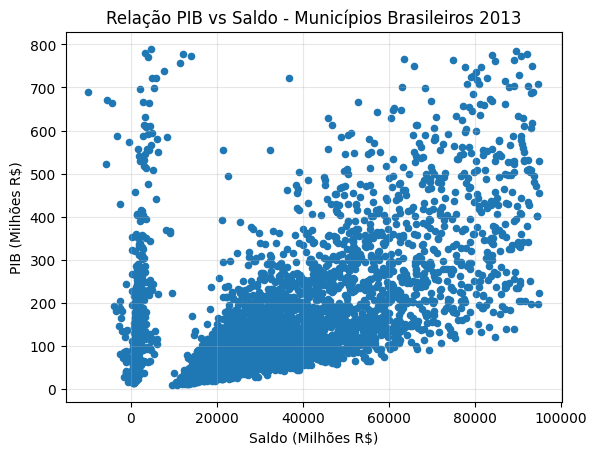

In [117]:
# Verificando se há uma relação linear entre as variáveis
plt.figure(figsize=(12, 8))

df_final_completo.plot(kind ='scatter', x = 'Saldo', y = 'PIB')

plt.xlabel('Saldo (Milhões R$)')
plt.ylabel('PIB (Milhões R$)')
plt.title('Relação PIB vs Saldo - Municípios Brasileiros 2013')
plt.grid(True, alpha=0.3)
plt.show()

In [118]:
#Dividindo o dataset em dados de treino e dados de teste
xTrain, xTest, yTrain, yTest = train_test_split(df_final_completo.Saldo, df_final_completo.PIB)

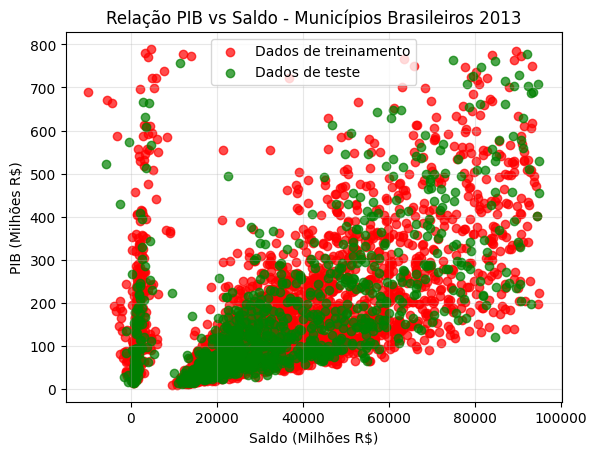

In [119]:
# Visualização da divisão entre treino e teste
plt.scatter(xTrain, yTrain, label = 'Dados de treinamento', color = 'r', alpha=.7)
plt.scatter(xTest, yTest, label = 'Dados de teste', color = 'g', alpha=.7)
plt.title("Divisão Teste/Treino")
plt.xlabel('Saldo (Milhões R$)')
plt.ylabel('PIB (Milhões R$)')
plt.title('Relação PIB vs Saldo - Municípios Brasileiros 2013')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [120]:
# Criando o modelo de regressão linear e iniciando o treinamento
model = LinearRegression()
model.fit(xTrain.values.reshape(-1,1),yTrain.values)
;

''

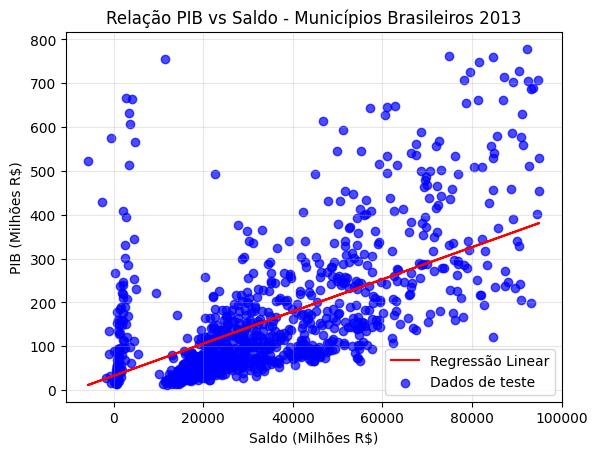

In [121]:
# Testando o modelo no dataset de teste
prediction = model.predict(xTest.values.reshape(-1,1))

# Visualização do teste
plt.plot(xTest, prediction, label= 'Regressão Linear', color = 'red') # Alterado para vermelho
plt.scatter(xTest, yTest, label = 'Dados de teste', color = 'blue', alpha =.7) # Alterado para azul
plt.xlabel('Saldo (Milhões R$)')
plt.ylabel('PIB (Milhões R$)')
plt.title('Relação PIB vs Saldo - Municípios Brasileiros 2013')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [122]:
# Atributos do modelo
print(f"R² : {model.score(xTest.values.reshape(-1,1), yTest.values)}")
print(f"Coeficiente : {model.coef_[0]}")
print(f"Constante : {model.intercept_}")

R² : 0.4127305160419238
Coeficiente : 0.003669525186373199
Constante : 32.522398830994604


### Conclusão

O R² indica que o saldo orçamentário só explica 34% da variação do PIB, o coeficiente indica que o aumento de 1% no saldo aumentaria o PIB em 0,004%. Considerando o fato de que há vários outros fatores que influenciam na economia do municipio e de que o scikit learning usa um algoritmos simples para a regressão linear, é seguro afirmar que o saldo orçamentário é uma métrica importante há ser usada para a análise do PIB, mas não deve ser a única.

# **Entrega 5 - Aprendizado Não-Supervisionado**

A intenção ao utilizar o Aprendizado Não-Supervisionado é descobrir grupos de municípios com perfis semelhantes de recuperação. Desta maneira segmentaremos os municípios brasileiros em grupos (clusters) com base em seus perfis para identificar diferentes padrões de recuperação após a crise de 2014-2016.

## **Criação das Tabelas para a Análise**

Primeiramente vamos criar uma tabela contendo cada município no final da crise (2016) e um tempo depois (2018).

In [123]:
# Carrega o arquivo original com todos os dados necessários
try:
    dados_completos = pd.read_csv('https://raw.githubusercontent.com/anaC-Fernandes/ProjetoDados/refs/heads/main/Datasets/BrStats.csv', sep=';', low_memory=False)
except Exception as e:
    print(f"Erro ao carregar o arquivo BrStats.csv: {e}")
    dados_completos = None

if dados_completos is not None:
    for col in ['PIB', 'Populacao']:
        dados_completos[col] = pd.to_numeric(
            dados_completos[col].astype(str).str.replace('.', '', regex=False).str.replace(',', '.'), 
            errors='coerce'
        )

    # --- Preparando os dados de 2016 (Fim da Crise) ---
    df_2016 = dados_completos[dados_completos['Ano'] == 2016].copy()
    df_2016.dropna(subset=['PIB', 'Populacao'], inplace=True)
    df_2016 = df_2016[df_2016['Populacao'] > 0]
    df_2016['PIB_per_capita_2016'] = (df_2016['PIB'] * 1000) / df_2016['Populacao']
    df_2016 = df_2016[['Municipio', 'UF', 'Regiao', 'PIB_per_capita_2016']]

    # --- Preparando os dados de 2018 (Pós-Crise) ---
    df_2018 = dados_completos[dados_completos['Ano'] == 2018].copy()
    df_2018.dropna(subset=['PIB', 'Populacao'], inplace=True)
    df_2018 = df_2018[df_2018['Populacao'] > 0] 
    df_2018['PIB_per_capita_2018'] = (df_2018['PIB'] * 1000) / df_2018['Populacao']
    df_2018 = df_2018[['Municipio', 'UF', 'PIB_per_capita_2018']]

    # --- Juntando os dados de 2016 e 2018 ---
    df_analise = pd.merge(df_2016, df_2018, on=['Municipio', 'UF'], how='inner')
    df_analise.dropna(inplace=True) # Remove qualquer dado nulo que possa ter restado

df_analise.head()

,Municipio,UF,Regiao,PIB_per_capita_2016,PIB_per_capita_2018
0,Campina do Monte Alegre,SP,Sudeste,"18.744,10","17.757,47"
1,Elói Mendes,MG,Sudeste,"20.165,90","18.431,26"
2,Silveiras,SP,Sudeste,"10.082,51","11.670,66"
3,Silva Jardim,RJ,Sudeste,"18.944,55","21.389,93"
4,Pindorama do Tocantins,TO,Norte,"10.708,20","11.829,08"


## **Padronizando os Dados para o Modelo**

Vamos utilizar o K-Means, que funciona medindo a "distância" entre os municípios, por isso precisamos padronizar os dados para o modelos,para que umaa variável maior não domine o cálculo e o resultado seja injusto.

Colocaremos então todas as nossas variáveis na mesma escala utilizando o StandardScaler, que calculará a média de todos os valores e seu desvio padrão. Em seguida, ele transformará cada valor da coluna na Z-score, que diz quantos desvios padrão este valor está acima ou abaixo da média da sua própria coluna.

In [124]:
from sklearn.preprocessing import StandardScaler

features_para_cluster = df_analise[['PIB_per_capita_2016', 'PIB_per_capita_2018']]

scaler = StandardScaler()

features_scaled = scaler.fit_transform(features_para_cluster)

## **Encontrando o Número Ideal de Grupos**

Como K-Means fará a separação dos municípios em K grupos, precisamos dizer para ele em quantos grupos os municípios devem ser separados. Para decidir isso utilizaremos o "Elbow Method", que usa o próprio K-Means.

Como o objetivo principal do K-Means é encontrar os centros dos grupos da melhor forma possível, fazendo com que a soma das distâncias de cada ponto (cada município) até o centro do seu grupo seja a menor possível, o Elbow Method calcula a "Inércia" (Soma das distâncias ao quadrado das amostras para o centro do cluster mais próximo, de acordo com a  documentação da biblioteca scikit-learn) de cada quantidade de grupo ao rodar o K-Means.

Ele então plota um gráfico que mostra que cada novo grupo faz a inércia cair muito, até chegar em um ponto (o "cotovelo") em que adicionar um novo grupo já não ajuda tanto assim, onde a queda na inércia é muito pequena. Este é o ponto de equilíbrio, e o número de grupo que utilizaremos.

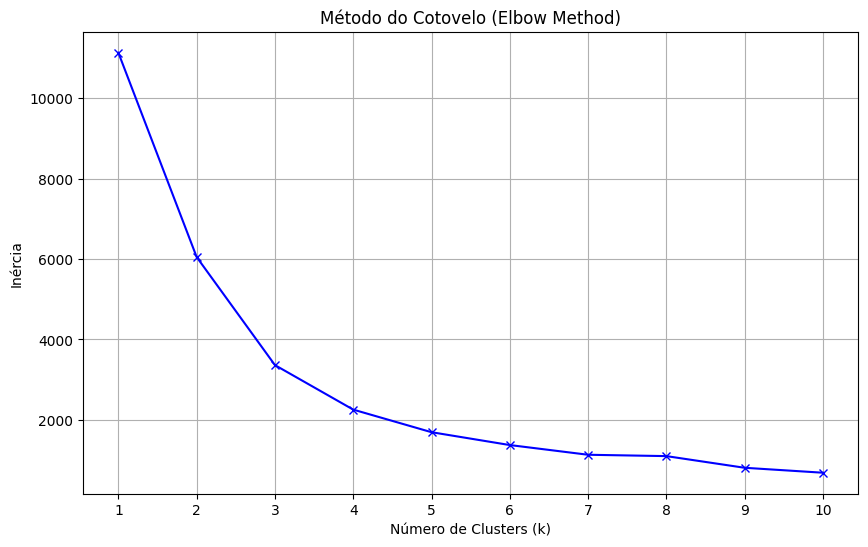

In [125]:
from sklearn.cluster import KMeans

inertia = []
K = range(1, 11) # Testar de 1 a 10 clusters

for k in K:
    # Cria e treina o modelo K-Means para o valor de k atual
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_model.fit(features_scaled)
    # Armazena a inércia (soma das distâncias quadráticas) do modelo treinado
    inertia.append(kmeans_model.inertia_)

# --- Plotando o Gráfico do Cotovelo ---
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xticks(K)
plt.grid(True)
plt.show()

Como é possível observar no gráfico, há uma diminuição da queda da inércia a partir do K=4, e a partir desse ponto temos quedas cada vez menores. Por esse motivo, utilizaremos nosso K=4.

## **Aplicando o K-Means**

Agora rodaremos o algoritmo K-Means com esse número e depois analisaremos as características de cada grupo que ele encontrou.

In [126]:
# O k ideal que escolhemos a partir do gráfico
k_ideal = 4

print(f"--- Rodando o modelo K-Means final com k={k_ideal} ---")

# Criar e treinar o modelo K-Means
kmeans_final = KMeans(n_clusters=k_ideal, random_state=42, n_init='auto')
kmeans_final.fit(features_scaled)

# Adicionar os rótulos dos clusters de volta ao nosso DataFrame original
# Usamos o .index de 'features_para_cluster' para garantir que os rótulos se alinhem corretamente
df_analise['Cluster'] = kmeans_final.labels_

# Analisar o perfil de cada cluster
# Agrupamos por cluster e calculamos a média de cada característica
perfil_dos_clusters = df_analise.groupby('Cluster')[['PIB_per_capita_2016', 'PIB_per_capita_2018']].mean()

print("\n--- Perfil Médio de Cada Cluster ---")
print(perfil_dos_clusters)

# Ver alguns exemplos de municípios em cada cluster
print("\n--- Exemplos de Municípios por Cluster ---")
for i in range(k_ideal):
    print(f"\n--- Cluster {i} ---")
    print(df_analise[df_analise['Cluster'] == i][['Municipio', 'UF', 'Regiao']].head())

--- Rodando o modelo K-Means final com k=4 ---

--- Perfil Médio de Cada Cluster ---
         PIB_per_capita_2016  PIB_per_capita_2018
Cluster                                          
0                  11.339,68            12.427,07
1                 173.130,95           235.758,24
2                  29.586,95            32.507,10
3                  63.621,20            73.161,10

--- Exemplos de Municípios por Cluster ---

--- Cluster 0 ---
                 Municipio  UF   Regiao
0  Campina do Monte Alegre  SP  Sudeste
1              Elói Mendes  MG  Sudeste
2                Silveiras  SP  Sudeste
3             Silva Jardim  RJ  Sudeste
4   Pindorama do Tocantins  TO    Norte

--- Cluster 1 ---
          Municipio  UF   Regiao
358         Aratiba  RS      Sul
539  Sales Oliveira  SP  Sudeste
752         Araporã  MG  Sudeste
796         Confins  MG  Sudeste
996   Muitos Capões  RS      Sul

--- Cluster 2 ---
                  Municipio  UF   Regiao
5   Santo Antônio do Jardim  SP  Su

Analisando os grupos criados chegamos nas seguintes conclusões: 

**Cluster 0**: Municípios de Renda Baixa - É o grupo com o menor PIB per capita. Apesar dos municípios terem apresentado um leve crescimento, partiram de uma base econômica mais baixa.

**Cluster 2**: Municípios de Renda Média - É o grupo que tem um PIB per capita quase 3 vezes maior que o Cluster 0. São cidades com uma economia mais desenvolvida e que também tiveram um crescimento sólido pós-crise.

**Cluster 3**: Municípios de Renda Alta - Este é o grupo dos municípios ricos. Eles já tinham um PIB per capita elevado em 2016 e continuaram a crescer, se distanciando ainda mais dos outros grupos.

**Cluster 1**: Os Pontos Fora da Curva (Super-Ricos) - Este grupo possui um PIB per capita tão absurdamente alto que esses municípios não representam uma realidade comum. Provavelmente são cidades com uma arrecadação gigantesca vinda de uma indústria específica, como hidrelétricas (Araporã-MG), grandes aeroportos (Confins-MG), ou agronegócio/indústria de ponta.

## **Visualização dos Clusters**

Agora podemos criar um gráfico para visualizar esses grupos, e para isso faremos um scatter plot.

A linha (onde y=x) nos mostra a Recuperação, pois os municípios acima da linha são aqueles cujo PIB per capita em 2018 foi maior que em 2016, indicando crescimento, e os municípios abaixo da linha são aqueles cujo PIB per capita em 2018 foi menor, indicando diminuição ou não recuperação.

--- Gerando o gráfico de dispersão dos clusters ---


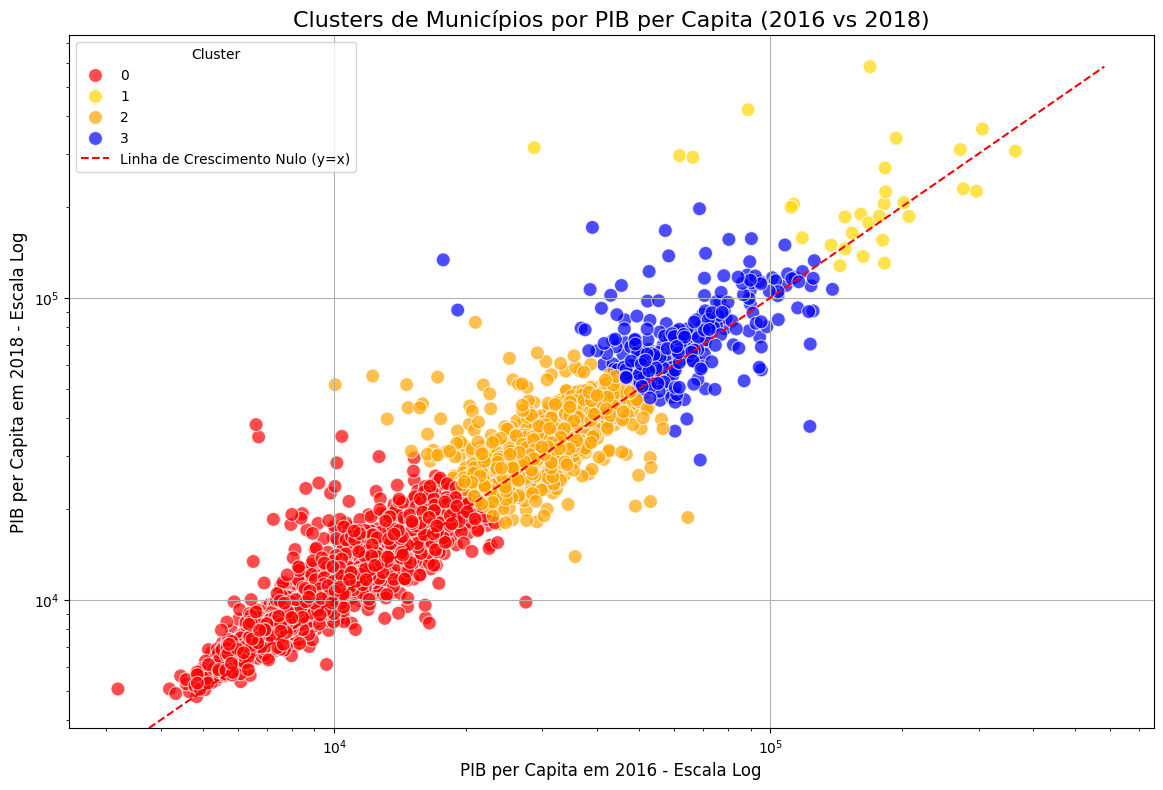

In [140]:
print("--- Gerando o gráfico de dispersão dos clusters ---")

cores_clusters = ['red', '#FFD700', 'orange', 'blue']  # '#FFD700' é um amarelo mais escuro (dourado)

plt.figure(figsize=(14, 9))


sns.scatterplot(
    data=df_analise, 
    x='PIB_per_capita_2016', 
    y='PIB_per_capita_2018', 
    hue='Cluster',  
    palette=cores_clusters,  
    s=100, 
    alpha=0.7,
)


max_val = max(df_analise['PIB_per_capita_2016'].max(), df_analise['PIB_per_capita_2018'].max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Linha de Crescimento Nulo (y=x)')


plt.xscale('log')
plt.yscale('log')


plt.title('Clusters de Municípios por PIB per Capita (2016 vs 2018)', fontsize=16)
plt.xlabel('PIB per Capita em 2016 - Escala Log', fontsize=12)
plt.ylabel('PIB per Capita em 2018 - Escala Log', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

Já o gráfico abaixo ainda mostra a dispersão, porém com as cores dos círculos sendo relativas as regiões.

--- Gerando o gráfico de dispersão dos clusters ---


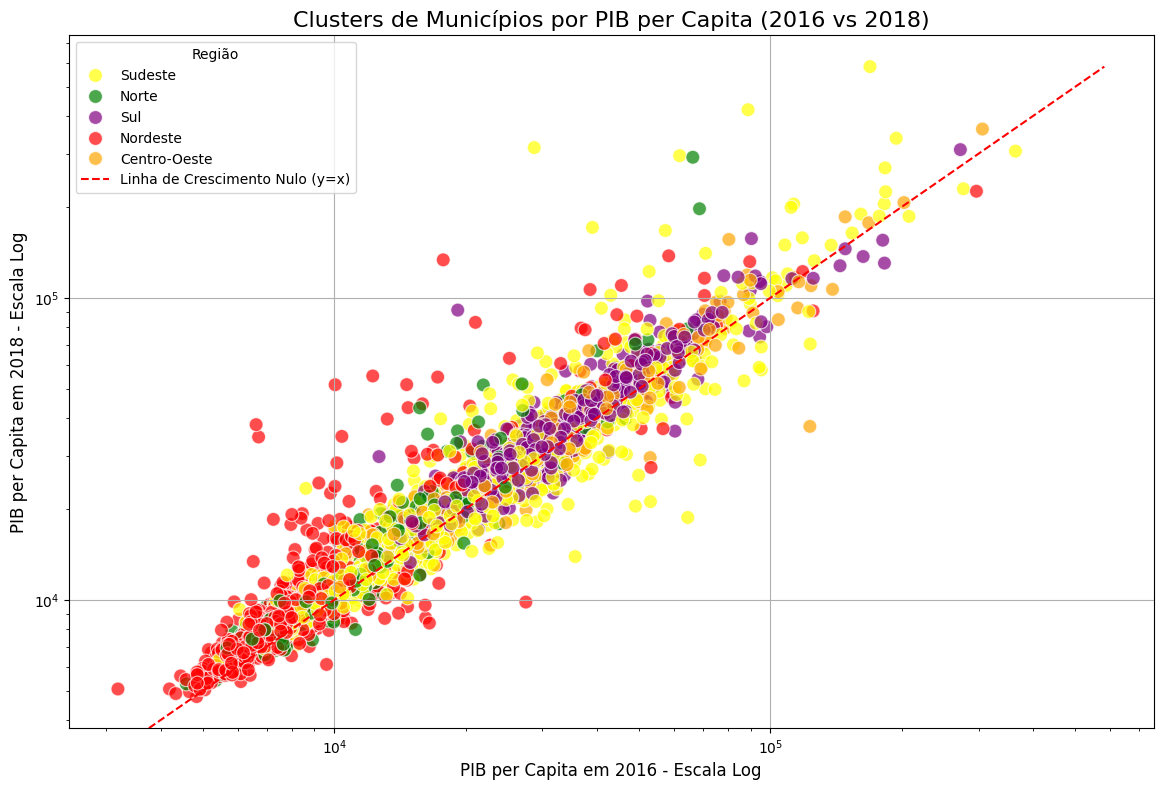

In [136]:
print("--- Gerando o gráfico de dispersão dos clusters ---")


cores_regioes = {
    'Norte': 'green',
    'Nordeste': 'red',
    'Centro-Oeste': 'orange',
    'Sudeste': 'yellow',
    'Sul': 'purple'
}

plt.figure(figsize=(14, 9))


sns.scatterplot(
    data=df_analise, 
    x='PIB_per_capita_2016', 
    y='PIB_per_capita_2018', 
    hue='Regiao', 
    palette=cores_regioes, 
    s=100, 
    alpha=0.7 
)


max_val = max(df_analise['PIB_per_capita_2016'].max(), df_analise['PIB_per_capita_2018'].max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Linha de Crescimento Nulo (y=x)')


plt.xscale('log')
plt.yscale('log')

# Títulos e legendas
plt.title('Clusters de Municípios por PIB per Capita (2016 vs 2018)', fontsize=16)
plt.xlabel('PIB per Capita em 2016 - Escala Log', fontsize=12)
plt.ylabel('PIB per Capita em 2018 - Escala Log', fontsize=12)
plt.legend(title='Região') # Alterado o título da legenda
plt.grid(True)
plt.show()

## **Conclusão**

Como já foi citado, a aplicação do algoritmo de aprendizado não-supervisionado K-Means permitiu dividir os municípios brasileiros em quatro perfis distintos, com base em seus respectivos PIBs per capita no período pós-crise (2016 vs. 2018). A análise desses grupos não apenas revela diferentes níveis de riqueza, mas também expõe a profunda desigualdade regional que caracteriza a economia do país.

- Cluster 0: Municípios de Renda Baixa (PIB per capita médio de R$ 12,4 mil em 2018)
- Cluster 2: Municípios de Renda Média (PIB per capita médio de R$ 32,5 mil em 2018)
- Cluster 3: Municípios de Renda Alta (PIB per capita médio de R$ 73,1 mil em 2018)
- Cluster 1: Super-Ricos (PIB per capita médio de R$ 235,7 mil em 2018)

A distribuição desses perfis pelas cinco grandes regiões do Brasil é mostrada na tabela abaixo.

In [129]:
contagem_regional = pd.crosstab(df_analise['Regiao'], df_analise['Cluster'])
print(contagem_regional)

Cluster          0   1    2    3
Regiao                          
Centro-Oeste   191   4  208   63
Nordeste      1689   1   81   23
Norte          373   1   69    6
Sudeste        975  18  571  104
Sul            224   6  836  122


### **A partir do resultados, e da tabela, podemos analisar a situação da cada região.**

**Regiões Nordeste e Norte**: Predominância de Renda Baixa
As regiões Nordeste e Norte são em sua maiora compostas por municípios do Cluster 0 (Renda Baixa). O Nordeste, principalmente, possui a maioria dos seus municípios (1.689 de 1.794) neste grupo. O resultado está de acordo com os dados do IBGE, que apontam que estas duas regiões possuem, historicamente, o menor PIB per capita do país.

**Região Sul**: Uma Forte "Classe Média" Municipal
Embora a região Sul possua municípios em todos os clusters, sua maior concentração está no Cluster 2 (Renda Média), com 836 municípios, sendo o maior número de todo o país neste grupo. Também conta com uma forte presença no Cluster 3 (Renda Alta). Isso no mostra uma economia mais desenvolvida, com menos municípios na faixa de renda mais baixa em comparação com outras regiões.

**Região Sudeste**: O Centro da Riqueza e do Contraste
Embora ainda tenha um número significativo de cidades no Cluster 0, a região Sudeste domina os grupos de maior riqueza. Ela possui o maior número de municípios no Cluster 3 (Renda Alta) (104) e abriga a maioria esmagadora dos municípios do Cluster 1 (Super-Ricos) (18 de um total de 30 no país). Este resultado comprova o status da região como o principal motor econômico do Brasil, concentrando a maior parte do PIB nacional, como frequentemente destacado em estudos do [IBGE](https://www.ibge.gov.br/estatisticas/economicas/contas-nacionais/9088-produto-interno-bruto-dos-municipios.html?edicao=29720&t=destaques) e como já foi visto ao longo das etapas desse projeto.

**Região Centro-Oeste**: A Força do Agronegócio
A região Centro-Oeste tem uma distribuição equilibrada entre os clusters de renda baixa e média, com uma forte presença no Cluster 3 (Renda Alta), cerca de 63 municípios. Sua presença tão marcante nesse grupo pode ser atribuída ao agronegócio, que consistentemente o PIB da região.

### **Por fim, respondendo a pergunta inicial do projeto: Quais regiões se recuperaram da recessão?**

Pode ver que as regiões Sul, Sudeste e Centro-Oeste concentram a maioria dos municípios de renda média, alta e super-ricos, o que indica uma capacidade de recuperação e crescimento superior. 
Já as regiões Norte e Nordeste permaneceram no perfil de baixa renda, sugerindo que a recuperação pós-crise não foi suficiente para alterar sua posição econômica no cenário nacional.